In [ ]:
import numpy as np
import sklearn
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import defaultdict
import copy

In [ ]:
STUDENT_ID = int("18493283")

In [ ]:
def make_dataset(student_id = STUDENT_ID):
    np.random.seed(STUDENT_ID)

    # Generate a linearly separable dataset
    X, y = make_classification(n_samples=500, n_features=2, n_classes=2, n_redundant=0,
                               n_clusters_per_class=1, class_sep=2, random_state=STUDENT_ID)

    # Assign protected groups (A and B)
    G = np.random.choice(['A', 'B'], size=len(y))

    # Ensure Group A has more selection class, Group B has more rejection class
    for i in range(len(y)):
        if y[i] == 1:
            G[i] = 'A' if np.random.rand() < 0.7 else 'B'
        else:
            G[i] = 'B' if np.random.rand() < 0.7 else 'A'
    print(f"Total Samples: {len(y)}")
    print(f"Selection Class (y=1): {np.sum(y == 1)}")
    print(f"Rejection Class (y=0): {np.sum(y == 0)}")
    print(f"Group A (Selection Class): {np.sum((G == 'A') & (y == 1))}")
    print(f"Group A (Rejection Class): {np.sum((G == 'A') & (y == 0))}")
    print(f"Group B (Selection Class): {np.sum((G == 'B') & (y == 1))}")
    print(f"Group B (Rejection Class): {np.sum((G == 'B') & (y == 0))}")

    return X, y, G


X, y, G = make_dataset()

Total Samples: 500
Selection Class (y=1): 250
Rejection Class (y=0): 250
Group A (Selection Class): 175
Group A (Rejection Class): 70
Group B (Selection Class): 75
Group B (Rejection Class): 180


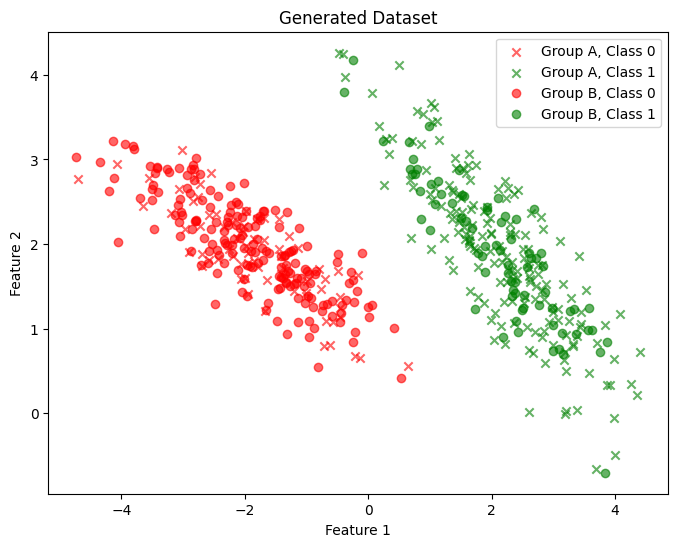

In [ ]:
def make_plot(X, y, groups):
    plt.figure(figsize=(8,6))
    for i, group in enumerate(['A', 'B']):
        for j, cls in enumerate([0, 1]):
            mask = (groups == group) & (y == cls)
            marker = 'x' if group == 'A' else 'o'
            color = 'red' if cls == 0 else 'green'
            label = f"Group {group}, Class {cls}"
            plt.scatter(X[mask, 0], X[mask, 1], marker=marker, color=color, label=label, alpha=0.6)

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Generated Dataset")
    plt.legend()
    plt.show()

make_plot(X, y, G)


In [ ]:
def train_logistic_regression(X, y):
    model = LogisticRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"Training Accuracy: {accuracy * 100:.2f}%")
    return model

model = train_logistic_regression(X, y)



Training Accuracy: 100.00%


In [ ]:
def demographic_parity(y_pred, group_labels):


    y_pred = list(y_pred)
    group_labels = list(group_labels)

    count_A, total_A = 0, 0
    count_B, total_B = 0, 0

    for i in range(len(y_pred)):
        if group_labels[i] == 'A':
            total_A += 1
            count_A += y_pred[i]
        elif group_labels[i] == 'B':
            total_B += 1
            count_B += y_pred[i]


    dp_A = count_A / total_A if total_A > 0 else 0
    dp_B = count_B / total_B if total_B > 0 else 0

    # Compute demographic parity difference
    dp = dp_A - dp_B

    print("\nDemographic Parity Calculation")
    print(f"P(ŷ = 1 | Group A): {dp_A:.3f}")
    print(f"P(ŷ = 1 | Group B): {dp_B:.3f}")
    print(f"Demographic Parity Difference: {dp:.3f}")

    return dp

dp = demographic_parity(model.predict(X), G)
print(f"Demographic Parity Difference: {dp}")



Demographic Parity Calculation
P(ŷ = 1 | Group A): 0.714
P(ŷ = 1 | Group B): 0.294
Demographic Parity Difference: 0.420
Demographic Parity Difference: 0.42016806722689076


In [ ]:
def balance(y_pred, X, G):

    y_pred = list(y_pred)
    G = list(G)

    total_samples = len(y_pred)
    total_A = sum(1 for g in G if g == 'A')
    total_B = sum(1 for g in G if g == 'B')

    r_X_A = total_A / total_samples
    r_X_B = total_B / total_samples

    selected_A = sum(1 for i in range(len(y_pred)) if y_pred[i] == 1 and G[i] == 'A')
    rejected_A = total_A - selected_A
    selected_B = sum(1 for i in range(len(y_pred)) if y_pred[i] == 1 and G[i] == 'B')
    rejected_B = total_B - selected_B

    r_1_A = selected_A / total_A if total_A > 0 else 0
    r_1_B = selected_B / total_B if total_B > 0 else 0
    r_0_A = rejected_A / total_A if total_A > 0 else 0
    r_0_B = rejected_B / total_B if total_B > 0 else 0

    min_selected_A = min(r_X_A / r_1_A, r_1_A / r_X_A) if r_1_A > 0 else float('inf')
    min_rejected_A = min(r_X_A / r_0_A, r_0_A / r_X_A) if r_0_A > 0 else float('inf')
    min_selected_B = min(r_X_B / r_1_B, r_1_B / r_X_B) if r_1_B > 0 else float('inf')
    min_rejected_B = min(r_X_B / r_0_B, r_0_B / r_X_B) if r_0_B > 0 else float('inf')

    bal = min(min_selected_A, min_rejected_A, min_selected_B, min_rejected_B)
    return bal

print(f"Balance: {balance(model.predict(X), X, G)}")


Balance: 0.5767012687427913


In [ ]:
def update_data(X, y, G, budget=0.1 * len(X)):

    X, y, G = list(X), list(y), list(G)
    num_changes = int(budget)

    print(f" Updating Dataset to Improve Fairness")
    print(f" Allowed budget for changes: {num_changes} samples.")

    indices_A_select = [i for i in range(len(y)) if G[i] == 'A' and y[i] == 1]
    indices_B_reject = [i for i in range(len(y)) if G[i] == 'B' and y[i] == 0]

    indices_A_reject = [i for i in range(len(y)) if G[i] == 'A' and y[i] == 0]
    indices_B_select = [i for i in range(len(y)) if G[i] == 'B' and y[i] == 1]
    removed_indices = []

    if len(indices_A_select) > len(indices_B_select):
        to_remove = min(num_changes, len(indices_A_select) - len(indices_B_select))
        removed_indices.extend(indices_A_select[:to_remove])

    if len(indices_B_reject) > len(indices_A_reject):
        to_remove = min(num_changes - len(removed_indices), len(indices_B_reject) - len(indices_A_reject))
        removed_indices.extend(indices_B_reject[:to_remove])

    X_updated = [X[i] for i in range(len(X)) if i not in removed_indices]
    y_updated = [y[i] for i in range(len(y)) if i not in removed_indices]
    G_updated = [G[i] for i in range(len(G)) if i not in removed_indices]

    print(f"Removed {len(removed_indices)} samples to balance groups.")
    return X_updated, y_updated, G_updated

X_prime, y_prime, G_prime = update_data(X, y, G)
model_prime = train_logistic_regression(X_prime, y_prime)

print(f"New Demographic Parity Difference: {demographic_parity(model_prime.predict(X_prime), G_prime)}")
print(f"New Balance: {balance(model_prime.predict(X_prime), X_prime, G_prime)}")


 Updating Dataset to Improve Fairness
 Allowed budget for changes: 50 samples.
Removed 50 samples to balance groups.
Training Accuracy: 100.00%

Demographic Parity Calculation
P(ŷ = 1 | Group A): 0.641
P(ŷ = 1 | Group B): 0.294
Demographic Parity Difference: 0.347
New Demographic Parity Difference: 0.34690799396681754
New Balance: 0.5190311418685122
